# CartPole-PPO implementation

PPO test in the CartPole environment

In [1]:
import gym
import minerl
import numpy as np
import tensorflow as tf 
from tensorflow import keras
from collections import deque
import random
from matplotlib import pyplot as plt

env = gym.make('CartPole-v1')

D:\Programmi\Anaconda\envs\gputest\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


## Memory

Class used to memorize the trajectory and calculate the advntage

In [2]:
class Memory(object):
    
    STATE = 0
    ACTION = 1
    ACTION_PROB = 2
    REWARD = 3
    DONE = 4
    
    def __init__(self, n_trajectories, gamma = 0.4):
        self.trajectories = np.empty(n_trajectories, dtype=object)
        self.gamma = gamma
        
        
    def collect(self, state, action, action_prob, reward, done, i_episode):
        if (self.trajectories[i_episode] == None):
            self.trajectories[i_episode] = deque(maxlen=N_STEPS)
        self.trajectories[i_episode].append((state, action, action_prob, reward, done))
        
    def calculate_advantages(self):
        advantages = []
        TDerrors = [] #list of all the delta, used to uopdate the critic
        
        for trajectory in self.trajectories:
            
            advantage_trajectory = [] #list of advantages for each element in a single trajectory
            #delta = []
            discounted_return = []
            
            #old_advantage = trajectory[-1][self.REWARD]
            #old_advantage =  trajectory[-1][self.REWARD] - ppo.return_v_values(trajectory[-1][self.STATE])
            #delta.append(old_advantage)
            discounted_return.append(trajectory[-1][self.REWARD])
            old_advantage = trajectory[-1][self.REWARD] - ppo.return_v_values(trajectory[-1][self.STATE]) 
            advantage_trajectory.append(old_advantage)

            for i in range(len(trajectory)-2,-1,-1):
                #delta.append(trajectory[i][self.REWARD] + self.gamma*ppo.return_v_values(trajectory[i+1][self.STATE]) - ppo.return_v_values(trajectory[i][self.STATE]))
                #new_advantage = delta[-1] + self.gamma*old_advantage
                
                discounted_return.append(trajectory[i][self.REWARD] + self.gamma*ppo.return_v_values(trajectory[i+1][self.STATE]))
                new_advantage = discounted_return[-1] - ppo.return_v_values(trajectory[-1][self.STATE]) + self.gamma*old_advantage
                
                advantage_trajectory.append(new_advantage[0])   
                
                old_advantage = new_advantage
            
            advantages.append(advantage_trajectory)
            TDerrors.append(discounted_return)
            
        #flat all trajectories in a single deque adding the advantages (easier to sample random batches)
        self.flat_trajectories(advantages, TDerrors)
    
    def flat_trajectories(self, advantages, TDerrors):
        
        size = 0
        for trajectory in self.trajectories:
            size = size + len(trajectory)
        
        self.flatten_trajectories = deque(maxlen=size)
        
        for trajectory, advantage, delta in zip(self.trajectories, advantages, TDerrors):
            for i in range(len(trajectory)-1,-1,-1):
                self.flatten_trajectories.append((trajectory[i][self.STATE], 
                                                  trajectory[i][self.ACTION], 
                                                  trajectory[i][self.ACTION_PROB], 
                                                  trajectory[i][self.REWARD], 
                                                  advantage[len(trajectory)-1-i], 
                                                  delta[len(trajectory)-1-i], 
                                                  trajectory[i][self.DONE]))
        
        
    #pick a random batch example from the flatten list of trajectories
    def sample_experiences(self, batch_size):
        if (len(self.flatten_trajectories) >= batch_size):
            indices = np.random.permutation(len(self.flatten_trajectories))[:batch_size]
        else:
            indices = np.random.permutation(len(self.flatten_trajectories))
        batch = [self.flatten_trajectories[index] for index in indices]
        #delete form the memory the used obervations
        for index in sorted(indices, reverse=True):
            del self.flatten_trajectories[index]
        states, actions, actions_prob, rewards, advantages, TDerrors, dones = [np.array([experience[field_index] for experience in batch]) for field_index in range(7)]
        return states, actions, actions_prob, rewards, advantages, TDerrors, dones
        
    def reset(self):
        for trajectory in self.trajectories:
            trajectory.clear()

# PPO class

$ s_{t+1} $ is the observed state after the current action $ a_t $ 

Actor update formula:
$ \theta_{t+1} = \theta_t + \alpha\nabla min(r_t(\theta)\hat{A}_t, clip(r_t(\theta),1-\epsilon,1+\epsilon)\hat{A}_t)$

Critic update formula:
$ w_{t+1} = w_t + \alpha\delta_t\nabla\hat{v}(s_t,w)$

Probability ratio $ r_t(\theta) \doteq $
$ \pi_\theta(a_t | s_t) \over \pi_{\theta_old}(a_t | s_t) $

Advantage:
$ \hat{A}_t \doteq \delta_t + (\gamma\lambda)\delta_{t+1} + (\gamma\lambda)^2\delta_{t+2} + ... + (\gamma\lambda)^{T-t+1}\delta_{T-1} = \delta_t + (\gamma\lambda)\hat{A}_{t+1}$

TDerror:
$ \quad \delta_t  \doteq $
$ r_t + \gamma\hat{v}(s_{t+1},w) - \hat{v}(s_t,w) $ $ \qquad $ (if $ s_t $ is terminal then $ \hat{v}(s_{t+1},w) = 0$)

In [5]:
class PPO(object):
    
    input_shape = [4] #[1] #500 states (400 reachable)
    n_outputs = env.action_space.n # 6 actions
    
    def __init__(self, n_episodes = 1, train_steps = 100, epsilon = 0.2, alpha = 0.95):
        self.actor = self.create_actor()
        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
        
        self.critic = self.create_critic()
        self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
        
        self.epsilon = epsilon
        self.alpha = alpha
        
        self.train_steps = train_steps
        
        self.memory = Memory(n_episodes)
        
    #create the NN of the actor
    # Given the state returns the probability of each action
    def create_actor(self):    
        actor = keras.Sequential([
            keras.layers.Dense(32, activation="relu", input_shape=self.input_shape),
            keras.layers.Dense(32, activation="relu"),
            keras.layers.Dense(self.n_outputs, activation = 'softmax') ])
        
        return actor
       
    #create the NN of the critic
    # Given the state returns the value function
    def create_critic(self):
        critic = keras.Sequential([
            keras.layers.Dense(32, activation="relu", input_shape=self.input_shape),
            keras.layers.Dense(32, activation="relu"),
            keras.layers.Dense(1) ])
        
        self.critic_loss_fn = tf.keras.losses.mean_squared_error
        
        return critic
      
    def play_one_step(self, env, observation):
        action, action_prob = self.select_action(observation)
        observation, reward, done, info = env.step(action)
        self.memory.collect(observation, action, action_prob, reward, done, i_episode)
        return observation, action, reward, done, info
        
    #select the action (returned as a number)
    def select_action(self, observation):
        
        # explanation: tf.expand_dims(observation['pov'], axis=0)
        # since we pass another input of shape (1,) -> we need to tell keras that is one image (it assumes the first dimension to be the batch)
        #action_probabilities = self.actor.predict(np.array([observation,])[np.newaxis, ...])[0]
        action_probabilities = self.actor.predict(np.array([observation,]))[0]
        #choosing an action usign randomly using a "roulette wheel" approach
        r = random.random()
        
        sum_probabilities = 0
        for i in range(len(action_probabilities)):
            sum_probabilities = sum_probabilities + action_probabilities[i]
            
            if (r <= sum_probabilities):
                action = i
                break
        
        return action, action_probabilities[action]
    
    def train(self, batch_size):
        self.memory.calculate_advantages()
        
        for i_step in range(self.train_steps):
            done = self.training_step(batch_size)
            if (done):
                break
        
        self.memory.reset()
        
    #training done on the memory (the advantages must be calculated before hand)
    def training_step(self, batch_size):
        #get experiences (parts of a trajectory) from the memory
        experiences = self.memory.sample_experiences(batch_size)
        states, actions, actions_prob, rewards, advantages, TDerrors, dones = experiences
        
        done = False
        if (len(states) != batch_size):
            done = True
        if (len(states) == 0):
            return True
            
        #compute the values for the update of the actor
        
        mask = tf.one_hot(actions, self.n_outputs)

        #array of shape (64,) into array of shape (64,1)
        #states =  np.array(np.array_split(states, len(states)))
        
        with tf.GradientTape() as tape:
            current_actions_prob = self.actor(states)
            
            current_action_prob = tf.reduce_sum(current_actions_prob*mask, axis=1, keepdims=True)
            old_actions_prob = tf.reshape(tf.convert_to_tensor(actions_prob), [len(states), 1])
            probability_ratio = tf.divide(tf.math.log(current_action_prob), tf.math.log(old_actions_prob))
        
            surrogate_arg_1 = tf.convert_to_tensor([probability_ratio[index]*advantages[index] for index in range(len(advantages))])
            surrogate_arg_2 = tf.convert_to_tensor(np.array([tf.keras.backend.clip(probability_ratio,1-self.epsilon,1+self.epsilon)[index]*advantages[index] for index in range(len(advantages))]).flatten())
            
            L = 0 - tf.minimum( surrogate_arg_1 , surrogate_arg_2 ) 
            loss = tf.reduce_mean(L)

        actor_weights = self.actor.trainable_variables
        grads = tape.gradient(loss, actor_weights)
        self.actor_optimizer.apply_gradients(zip(grads, actor_weights))
        
        #update of the critic. We need the target is the TD error
        target_v_values = tf.reshape(tf.convert_to_tensor(np.asarray(self.alpha*TDerrors).astype('float32')), (len(states), 1))

        with tf.GradientTape() as tape:
            all_v_values = self.critic(states)
            v_values = tf.reduce_sum(all_v_values*mask, axis=1, keepdims=True)
            loss = tf.reduce_mean(self.critic_loss_fn(target_v_values, v_values))
        grads = tape.gradient(loss, self.critic.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(grads, self.critic.trainable_variables))
        
        #since v changed we need to re-calculate the advantages
        #self.memory.calculate_advantages()
        
        return done
    
    def return_v_values(self, observation):
        v = self.critic.predict(np.array( [observation,]))[0]
        #v = self.critic.predict(np.array( [observation,])[np.newaxis, ...])[0]
        return v

## Training

In [6]:
N_EPOCHS = 200
N_EPISODES = 5 # number of trajectories collected in one epoch
N_STEPS = 100 # max number of step for each episode

TRAIN_STEPS = 100 # number of max steps done during training. if the number of samples is less than TRAIN_STEPS*BATCH_SIZE will stop early after completing the training on all the samples
BATCH_SIZE = 16

ppo = PPO(n_episodes = N_EPISODES, train_steps = TRAIN_STEPS)

rewards = []


for i_epoch in range(N_EPOCHS):
    
    epoch_reward = 0.0
    
    for i_episode in range(N_EPISODES):
        
        observation = env.reset()
        
        episode_reward = 0.0
        
        for i_step in range(N_STEPS):   
            
            observation, action, reward, done, info = ppo.play_one_step(env, observation)

            #env.render()
            episode_reward = episode_reward + reward

            if(done or i_step == N_STEPS-1):
                #print("Epoch {} Episode {} terminated after {} steps with total reward: {}".format(i_epoch, i_episode, i_step, episode_reward))
                epoch_reward = epoch_reward + episode_reward
                break
    
    print("Epoch {} terminated with average reward {}".format(i_epoch, epoch_reward/N_EPISODES))
    #print("============================================================================")
    rewards.append(epoch_reward/N_EPISODES)
    
    ppo.train(batch_size = 16)
    
env.close()

Epoch 0 terminated with average reward 25.2


C:\Users\paci3\AppData\Local\Temp\ipykernel_10648\1946309144.py:82: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  states, actions, actions_prob, rewards, advantages, TDerrors, dones = [np.array([experience[field_index] for experience in batch]) for field_index in range(7)]


Epoch 1 terminated with average reward 32.4
Epoch 2 terminated with average reward 25.6
Epoch 3 terminated with average reward 27.0
Epoch 4 terminated with average reward 33.0
Epoch 5 terminated with average reward 31.0
Epoch 6 terminated with average reward 32.4
Epoch 7 terminated with average reward 49.8
Epoch 8 terminated with average reward 40.0
Epoch 9 terminated with average reward 25.8
Epoch 10 terminated with average reward 20.6
Epoch 11 terminated with average reward 21.8
Epoch 12 terminated with average reward 19.8
Epoch 13 terminated with average reward 34.0
Epoch 14 terminated with average reward 27.0
Epoch 15 terminated with average reward 29.2
Epoch 16 terminated with average reward 24.0
Epoch 17 terminated with average reward 23.8
Epoch 18 terminated with average reward 19.2
Epoch 19 terminated with average reward 17.0
Epoch 20 terminated with average reward 14.4
Epoch 21 terminated with average reward 14.2
Epoch 22 terminated with average reward 16.2
Epoch 23 terminated

KeyboardInterrupt: 

## Plot graph

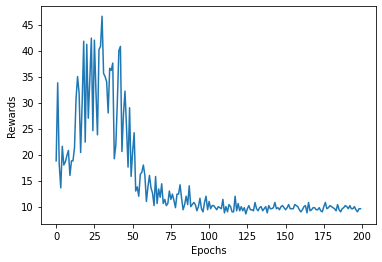

In [5]:
#TEST 1 using discounted return and A = G - v(t)
epochs = range(N_EPOCHS)

plt.plot(epochs, rewards)

plt.xlabel("Epochs")
plt.ylabel("Rewards")

plt.show()

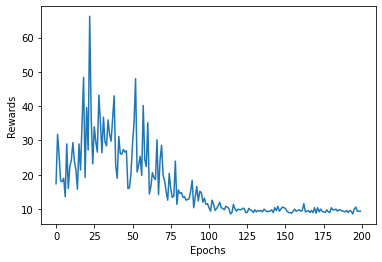

In [5]:
#TEST 2 using discounted return and A_t+1 = TDError + A_t but v is updated on G_t
epochs = range(N_EPOCHS)

plt.plot(epochs, rewards)

plt.xlabel("Epochs")
plt.ylabel("Rewards")

plt.show()

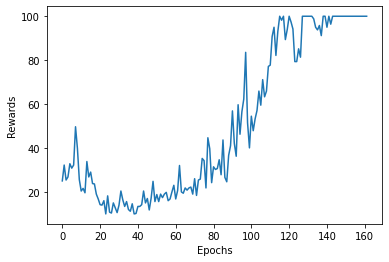

In [8]:
#TEST 3 using discounted return and A_t+1 = TDError + A_t but v is updated on G_t using log of the probabilities
epochs = range(162)

plt.plot(epochs, rewards)

plt.xlabel("Epochs")
plt.ylabel("Rewards")

plt.show()